In [2]:
import pandas as pd
import numpy as np
import json
import pickle
import pathlib
import nltk
from nltk.stem.lancaster import LancasterStemmer
stemmer = LancasterStemmer()
from sklearn.feature_extraction.text import CountVectorizer
import inflect
import re, string, unicodedata
from nltk import word_tokenize, sent_tokenize
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from nltk import ngrams
nltk.download('punkt')

# linear regression feature importance
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot

[nltk_data] Downloading package punkt to C:\Users\Luk Chi
[nltk_data]     Heng\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Import intents and stop words

In [3]:
with open("intents.json", encoding="utf8") as f:
    intentsJson = json.loads(f.read())
with open("stop_words.json", encoding="utf8") as f:
    stop_words = json.loads(f.read())

In [4]:
intentList = []
patternList = []
for intent in intentsJson["intents"]:
    for pattern in intent["patterns"]:
        intentList.append(intent['tag'])
        patternList.append(pattern)

# Format into dataframe

In [7]:
data = {'Pattern': patternList, 'Intent': intentList}
df = pd.DataFrame(data, columns = ['Pattern', 'Intent'])

# Helper methods to normalize training data

In [8]:
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize_text(words):
    # words = remove_non_ascii(words)
    words = to_lowercase(words)
    # words = remove_punctuation(words)
    # words = replace_numbers(words)
    # words = remove_stopwords(words)
    # words = stem_words(words)
    # words = lemmetize_verbs(words)
    return words
def remove_stopwords(text):
    word_list = text.split()
    text = ' '.join([x for x in word_list if x not in stop_words])
    return text

def pad(text):
    word_list = text.split()
    word_list.insert(0, "<start>")
    word_list.insert(len(word_list), "<end>")
    text = ' '.join([x for x in word_list if x not in stop_words])
    return text

def tokenize(text):
    return nltk.word_tokenize(text)

def text_prepare(text):
    # text = ' '.join([x for x in normalize_text(tokenize(text))])
    
    return re.sub(r'[^\w]', ' ', text).lower()

# Normalize data and append to dataframe

In [10]:
df['Cleaned Pattern'] = [text_prepare(x) for x in df['Pattern']]
le = LabelEncoder()
df['label'] = le.fit_transform(df['Intent'])

# df

In [11]:
df['Query Length'] = [len(x.split()) for x in df['Cleaned Pattern']]
df

Pattern     Intent  \
0           What is the <ATTR> of <OBJ> on <TEMPORAL>  Get stats   
1                                      What is <ATTR>  Get stats   
2                                     <ATTR> of <OBJ>  Get stats   
3                                        <OBJ> <ATTR>  Get stats   
4                                         <OBJ> stats  Get stats   
..                                                ...        ...   
93       cause of <OBJ> <ATTR> <DIRECTION> <TEMPORAL>     Reason   
94                       why <OBJ> <ATTR> <DIRECTION>     Reason   
95                    <OBJ> <ATTR> <DIRECTION> reason     Reason   
96            <OBJ> <ATTR> <DIRECTION> <TEMPORAL> why     Reason   
97  what could be the cause of <OBJ> <ATTR> <DIREC...     Reason   

                                      Cleaned Pattern  label  Query Length  
0           what is the  attr  of  obj  on  temporal       0             8  
1                                      what is  attr       0             3  
2                                      attr  of  obj       0             3  
3                                         obj   attr       0             2  
4                                          obj  stats      0             2  
..                                                ...    ...           ...  
93       cause of  obj   attr   direction   temporal       1             6  
94                       why  obj   attr   direction       1             4  
95                     obj   attr   direction  reason      1             4  
96             obj   attr   direction   temporal  why      1             5  
97  what could be the cause of  obj   attr   direc...      1            10  

[98 rows x 5 columns]

# Unigram for intent classification
### The vocab will consist of tokens with a single word


In [12]:
# Get vocab list

wordfreq = {}
for index in df.index:
    tokens = nltk.word_tokenize(df['Cleaned Pattern'][index])
    for token in tokens:
        if token not in wordfreq.keys():
            wordfreq[token] = 1
        else:
            wordfreq[token] += 1

print(len(wordfreq.keys())) 

56


### For each training example, vectorize it with one hot encoding

In [14]:
# BoW for each training sample

query_vectors = []
for index in df.index:
    query_tokens = nltk.word_tokenize(df['Cleaned Pattern'][index])
    query_vec = []
    for token in wordfreq:
        if token in query_tokens:
            query_vec.append(1)
        else:
            query_vec.append(0)
    query_vectors.append(query_vec)

one_gram_vocab = [x for x in wordfreq.keys()]


### Save unigram vocab to file

In [15]:
pickle.dump(one_gram_vocab, open('unigrams.pkl', 'wb'))

### Each training example is represented as a vector of 1s and 0s

In [16]:
n = 0

onegram = pd.DataFrame()
for t in wordfreq.keys():
    words = []
    for q in query_vectors:
        words.append(q[n])
    n = n+1
    onegram[t] = words
onegram

what  is  the  attr  of  obj  on  temporal  stats  statistics  ...  has  \
0      1   1    1     1   1    1   1         1      0           0  ...    0   
1      1   1    0     1   0    0   0         0      0           0  ...    0   
2      0   0    0     1   1    1   0         0      0           0  ...    0   
3      0   0    0     1   0    1   0         0      0           0  ...    0   
4      0   0    0     0   0    1   0         0      1           0  ...    0   
..   ...  ..  ...   ...  ..  ...  ..       ...    ...         ...  ...  ...   
93     0   0    0     1   1    1   0         1      0           0  ...    0   
94     0   0    0     1   0    1   0         0      0           0  ...    0   
95     0   0    0     1   0    1   0         0      0           0  ...    0   
96     0   0    0     1   0    1   0         1      0           0  ...    0   
97     1   0    1     1   1    1   0         1      0           0  ...    0   

    problems  why  cause  get  reason  caused  come  could  be  
0          0    0      0    0       0       0     0      0   0  
1          0    0      0    0       0       0     0      0   0  
2          0    0      0    0       0       0     0      0   0  
3          0    0      0    0       0       0     0      0   0  
4          0    0      0    0       0       0     0      0   0  
..       ...  ...    ...  ...     ...     ...   ...    ...  ..  
93         0    0      1    0       0       0     0      0   0  
94         0    1      0    0       0       0     0      0   0  
95         0    0      0    0       1       0     0      0   0  
96         0    1      0    0       0       0     0      0   0  
97         0    0      1    0       0       0     0      1   1  

[98 rows x 56 columns]

In [18]:
# onegram_with_length = onegram
# onegram_with_length['']

In [19]:
# append label with BoW
pd.set_option('display.max_rows', None)
onegram['label'] = [x for x in df['label']]
# onegram

### Split training data and label

In [20]:
# split one gram to feature and label

X_1 = onegram.iloc[:, 0:-1]
y_1 = onegram.iloc[:, -1:]


### Model was trained using extra tree classifer

C:\Users\Luk Chi Heng\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[1.92859808e-02 1.40800274e-02 1.54630505e-02 1.54433804e-02
 2.09361356e-02 3.53880913e-03 2.06087056e-02 1.37896991e-02
 4.79554075e-04 3.86998450e-04 3.90264340e-04 1.88348749e-03
 1.25304352e-03 8.70072634e-03 6.39476399e-03 1.65726525e-03
 1.92839516e-02 1.36145685e-02 1.32563643e-02 4.02323942e-02
 4.72312129e-02 2.93349839e-04 2.81783338e-04 1.16464786e-02
 1.97394446e-04 4.73892030e-03 3.29552657e-02 6.45582789e-03
 3.30735869e-04 1.14120362e-03 2.55973030e-05 2.06334077e-02
 5.97701619e-03 2.83590868e-02 1.06268691e-01 1.31626354e-03
 3.13146431e-02 1.04294043e-01 9.99168477e-03 2.00020847e-03
 9.20325234e-04 4.11620837e-02 1.03591981e-02 7.47900424e-03
 1.40553088e-02 9.75944645e-03 1.49565968e-03 2.75654761e-02
 8.05535252e-02 6

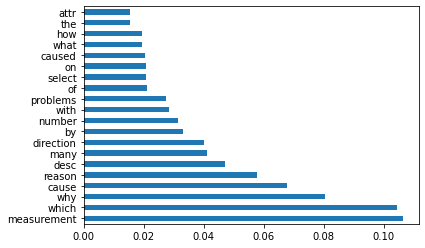

In [21]:

model = ExtraTreesClassifier()
model.fit(X_1,y_1)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_1.columns)
feat_importances.nlargest(20).plot(kind='barh')
print(model.score(X_1, y_1))
plt.show()

In [127]:
x1_train, x1_test, y1_train, y1_test = train_test_split(X_1, y_1)
# x1_train

In [128]:
model1 = ExtraTreesClassifier()
model1.fit(x1_train, y1_train)
model1.score(x1_test, y1_test)

ipykernel_launcher:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.92

### Save model to file

In [129]:
with open('model1gram.pkl','wb') as f:
    pickle.dump(model1,f)

#  Bigram model training
### The vocab for bigrams will have tokens made up by 2 words

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

count_two_vect = CountVectorizer(ngram_range=(2,2))
# count_onetwo_vect = CountVectorizer(ngram_range=(1,2))
X_train_two_counts = count_two_vect.fit_transform(df['Cleaned Pattern'])
two_gram_vocab = count_two_vect.get_feature_names()
# two_gram_vocab


### Helper method to create bigram vocab

In [18]:
def get_ngrams(text, n):
    n_grams = ngrams(word_tokenize(text), n)
    return [ ' '.join(grams) for grams in n_grams]

In [25]:
# Bow 2grams 

query_2_vectors = []
for index in df.index:
    n = 2
    twograms = get_ngrams(df['Cleaned Pattern'][index], n)
    # print(twograms)
    # for x in twograms:
    #     print(x)
    query_2_vec = []
    for t in two_gram_vocab:
        if t in twograms:
            query_2_vec.append(1)
        else:
            query_2_vec.append(0)
    query_2_vectors.append(query_2_vec)

# query_2_vectors

In [20]:
pickle.dump(two_gram_vocab, open('bigrams.pkl', 'wb'))


In [27]:
n = 0

twogram = pd.DataFrame()
for t in two_gram_vocab:
    words = []
    for q in query_2_vectors:
        words.append(q[n])
    n = n+1
    twogram[t] = words

twogram

1        0        0         0          0        0             0   
44        0        0        0         0          0        0             0   
45        0        0        0         0          0        0             0   
46        0        0        0         0          0        0             0   
47        0        0        0         0          0        0             0   
48        0        0        0         0          0        0             0   
49        0        0        0         1          0        0             0   
50        0        0        0         0          0        0             0   
51        0        0        0         0          0        0             0   
52        0        0        0         0          0        0             0   
53        0        0        0         0          0        0             0   
54        0        0        0         0          0        0             0   
55        0        0        0         0          0        0             0   
56        0        0        0         0          0        0             0   
57        0        0        0         0          0        0             0   
58        0        0        0         0          0        0             0   
59        0        0        0         0          0        0             0   
60        0        1        0         0          0        0             0   
61        0        0        0         0          0        0             0   
62        0        0        0         0          0        0             0   
63        0        0        0         0          0        0             0   
64        0        0        0         0          0        0             0   
65        0        0        0         0          0        0             0   
66        0        0        0         0          0        0             0   
67        0        0        0         0          0        0             0   
68        0        0        0         0          0        0             0   
69        0        0        0         0          0        0             0   
70        0        0        0         0          0        0             0   
71        0        0        0         0          0        0             0   
72        0        0        0         0          0        0             0   
73        0        0        0         0          0        0             0   
74        0        0        0         0          0        0             0   
75        0        0        0         0          0        0             0   
76        0        0        0         0          0        1             0   
77        0        0        0         0          0        0             0   
78        0        0        0         0          0        0             0   
79        0        0        0         0          0        0             0   
80        0        0        0         0          0        0             0   
81        0        0        0         0          0        0             0   
82        0        0        0         0          0        0             0   
83        0        0        0         0          0        0             0   
84        0        0        0         0          0        0             0   
85        0        0        0         0          0        0             0   
86        0        0        0         0          0        0             0   
87        0        0        0         0          0        0             0   
88        0        0        0         0          0        0             0   
89        0        0        0         0          0        0             0   
90        0        0        0         0          0        0             0   
91        0        0        0         0          0        0             0   
92        0        0        0         0          1        0             0   
93        0        0        0         0          0        0             0   
94        0        0        0         0          0        0             0   
95    

In [28]:
twogram['label'] = [x for x in df['label']]

In [29]:
X_2 = twogram.iloc[:, 0:-1]
y_2 = twogram.iloc[:, -1:]

# X_2
# y_2

C:\Users\Luk Chi Heng\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[3.78561561e-03 2.50330794e-05 1.40185245e-05 1.18327321e-03
 6.03422380e-04 5.38609998e-03 2.68961182e-04 4.75476993e-04
 3.72167982e-02 2.69266087e-02 1.13775686e-03 4.48112599e-02
 3.68563968e-02 1.00885641e-02 6.79662948e-04 1.38128988e-02
 5.06308781e-03 3.19547259e-04 3.98392844e-05 1.25715001e-02
 1.17585773e-02 7.51278523e-03 1.22015316e-02 4.03935534e-03
 1.00306572e-03 2.76111487e-02 1.03810935e-02 3.13628134e-03
 4.76574930e-04 1.28046041e-03 2.70073213e-03 7.09486225e-03
 2.54459290e-02 1.79400989e-02 1.07715868e-02 3.24050719e-03
 2.55747219e-03 7.59948427e-03 1.74511715e-03 6.14215012e-04
 1.53030442e-02 1.05959202e-02 3.26856523e-03 8.08761028e-06
 4.75295471e-03 7.46333228e-04 5.27213381e-03 3.27897866e-04
 1.52937399e-03 7

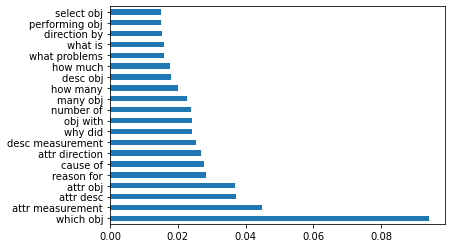

In [30]:

model2 = ExtraTreesClassifier()
model2.fit(X_2,y_2)
print(model2.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model2.feature_importances_, index=X_2.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [159]:
x2_train, x2_test, y2_train, y2_test = train_test_split(X_2, y_2)

In [160]:
model2 = ExtraTreesClassifier()
model2.fit(x2_train, y2_train)
model2.score(x2_test, y2_test)

ipykernel_launcher:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.84

In [161]:
with open('model2gram.pkl','wb') as f:
    pickle.dump(model2,f)

# load
# with open('model2gram.pkl', 'rb') as f:
#     clf2 = pickle.load(f)


In [56]:
# clf2.score(x2_test, y2_test)

# UniBigrams
### Combine unigrams and bigrams
### The vocab now with content tokens of 1 word and 2 words


In [21]:
from sklearn.feature_extraction.text import CountVectorizer

count_onetwo_vect = CountVectorizer(ngram_range=(1,2))
# count_onetwo_vect = CountVectorizer(ngram_range=(1,2))
X_train_onetwo_counts = count_onetwo_vect.fit_transform(df['Cleaned Pattern'])
onetwo_gram_vocab = count_onetwo_vect.get_feature_names()
string = 'all attr between obj'
string_list = get_ngrams(string, 1)
string_list.extend(get_ngrams(string,2))
count = []
for x in onetwo_gram_vocab:
    # if re.search(r'\b' + x + r'\b', string):
    if x in string_list:
        count.append(1)
        print(x)
    else:
        count.append(0)

print(string_list) 
# c = pd.array(count)
# onetwo_gram_vocab

all
attr
attr between
between
between obj
obj
['all', 'attr', 'between', 'obj', 'all attr', 'attr between', 'between obj']


In [22]:
onetwogram = pd.DataFrame()

In [23]:
onecol = X_1.columns
for o in onecol:
    onetwogram[o] = X_1[o].values

NameError: name 'X_1' is not defined

In [37]:
twocol = X_2.columns
for o in twocol:
    onetwogram[o] = X_2[o].values

In [38]:
# onetwogram

C:\Users\Luk Chi Heng\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
[1.27718100e-02 4.34585910e-03 3.71968879e-03 4.57615911e-03
 5.05042833e-03 5.41327914e-04 5.27548002e-03 7.04390069e-03
 3.21295621e-04 7.88542002e-05 1.54357381e-04 1.19683153e-03
 2.21685990e-04 6.33012607e-03 1.72587541e-03 0.00000000e+00
 8.51455470e-03 8.66967722e-03 5.32628367e-03 1.81321487e-02
 3.25414963e-02 1.91029862e-04 0.00000000e+00 4.18665194e-03
 2.25297715e-05 1.81003957e-03 1.15428491e-02 2.26191349e-03
 7.74773808e-05 1.57963530e-04 0.00000000e+00 7.37487910e-03
 1.96754674e-03 1.20582482e-02 5.73941679e-02 4.26740378e-04
 1.48718706e-02 4.83191565e-02 2.80434247e-03 8.05183818e-04
 2.63302062e-04 1.41808617e-02 2.81829444e-03 2.99834218e-03
 6.29653581e-03 7.53066867e-03 3.65201383

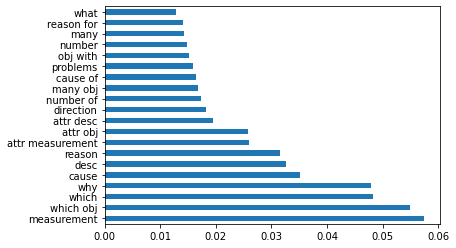

In [39]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(onetwogram, y_2)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=onetwogram.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [40]:
x12_train, x12_test, y12_train, y12_test = train_test_split(onetwogram.iloc[:,:-1], onetwogram.iloc[:,-1:])

In [179]:
model12 = ExtraTreesClassifier()
model12.fit(x12_train, y12_train)
model12.score(x12_test, y12_test)

ipykernel_launcher:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


1.0

In [172]:
uni_bi_gram_vocab = onetwogram.columns
# for a in uni_bi_gram_vocab:
#     print(a)




In [173]:
pickle.dump(uni_bi_gram_vocab, open('unibigrams.pkl', 'wb'))


In [180]:
with open('model12gram.pkl','wb') as f:
    pickle.dump(model12,f)